# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [30]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [31]:
# Import essential libraries

import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
import pathlib
import pandas as pd

Load the dataset.

In [33]:
# Load and unzip the dataset

import zipfile

zip_ref = zipfile.ZipFile('/content/data.zip','r')
zip_ref.extractall('/content/')

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [79]:
# Create a function to load the raw images


###loading images using the helpful image_dataset_from_directory utility.
###image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
###label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data',
    label_mode='categorical',
    batch_size=8,
    image_size=(180, 180),
    shuffle=True,
    seed=42,

)


Found 7625 files belonging to 7 classes.


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [35]:
# Get the images and their labels

### listing all the classes/labels
###class names can be found in class_names attribute on thes dataset.
###These correspond to the directory names in alphabetical order.

class_names=dataset.class_names
class_names




['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

In [36]:
len(dataset)

954

In [37]:
for image,label in dataset.take(1):
  print(image.shape)
  print(label.shape)

(8, 180, 180, 3)
(8, 7)


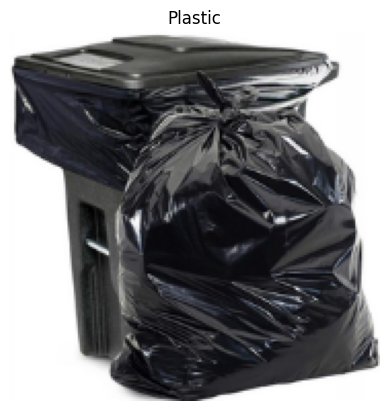

In [38]:
# visualize sample image
for image,label in dataset.take(1):
  plt.imshow(image[0].numpy().astype('uint8'))
  plt.title(class_names[np.argmax(label[0].numpy())])
  plt.axis("off")

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [107]:
# Visualise Data Distribution

directory='/content/data'
count= []
for p in pathlib.Path(directory).iterdir():
    if p.is_dir():
        count.append(len([name for name in os.listdir(p) if os.path.isfile(os.path.join(p, name))]))

sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

df=pd.DataFrame(list(zip(sub_directory,count)),columns =['Category', 'No_of_Images'])
df.sort_values(by='No_of_Images',ascending=False,inplace=True)
df


,Category,No_of_Images
2,Plastic,2295
3,Paper,1030
6,Other,1010
4,Food_Waste,1000
1,Metal,1000
5,Glass,750
0,Cardboard,540


<Axes: xlabel='No_of_Images', ylabel='Category'>

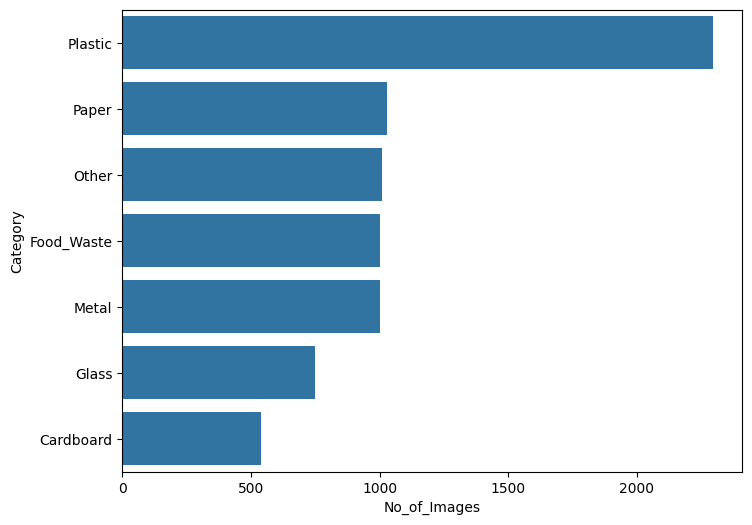

In [108]:
plt.figure(figsize=(8, 6))
sns.barplot(x="No_of_Images", y="Category", data=df)


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

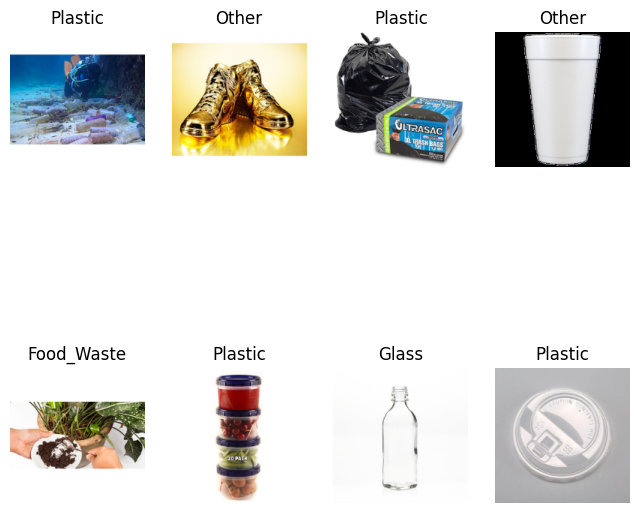

In [40]:
# Visualise Sample Images (across different labels)


plt.figure(figsize=(8,8))
for image,label in dataset.take(1):
  for i in range(8):
    ax=plt.subplot(2,4,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(label[i].numpy())])
    plt.axis("off")


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [109]:
# Find the smallest and largest image dimensions from the data set



directory='/content/data/'

max_width=0
max_height=0
min_width=100000
min_height=100000
cnt=0

for p in pathlib.Path(directory).iterdir():
    if p.is_dir():
      for name in os.listdir(p):
        cnt=cnt+1
        img = Image.open(os.path.join(p, name))
        width, height = img.size
        if width>max_width:
          max_width=width
        if height>max_height:
          max_height=height
        if width<min_width:
          min_width=width
        if height<min_height:
          min_height=height
print (cnt)
print (f'max_height:{max_height},max_width:{max_width}')
print (f'min_height:{min_height},min_width:{min_width}')



7625
max_height:256,max_width:256
min_height:256,min_width:256


In [110]:
# Resize the image dimensions

## resizing to (180,180)


size=(180,180)
directory='/content/data/'

for p in pathlib.Path(directory).iterdir():
    if p.is_dir():
      for name in os.listdir(p):
        img = Image.open(os.path.join(p, name))
        img = img.resize(size)
        img.save(os.path.join(p, name))

In [111]:
## checking image dimensions after resizing
directory='/content/data/'

max_width=0
max_height=0
min_width=100000
min_height=100000
cnt=0

for p in pathlib.Path(directory).iterdir():
    if p.is_dir():
      for name in os.listdir(p):
        cnt=cnt+1
        img = Image.open(os.path.join(p, name))
        width, height = img.size
        if width>max_width:
          max_width=width
        if height>max_height:
          max_height=height
        if width<min_width:
          min_width=width
        if height<min_height:
          min_height=height
print (cnt)
print (f'max_height:{max_height},max_width:{max_width}')
print (f'min_height:{min_height},min_width:{min_width}')



7625
max_height:180,max_width:180
min_height:180,min_width:180


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [43]:
# Encode the labels suitably

## We have already encoded the labels using image_dataset_from_directory utility.

In [44]:
## The image_batch is a tensor of the shape (8, 180, 180, 3).
## This is a batch of 8 images of shape 180x180x3 (the last dimension refers to color channels RGB).
## The label_batch is a tensor of the shape (8,7), these are corresponding labels to the 8 images.

for image,label in dataset.take(1):
  print(image.shape)
  print(label.shape)


(8, 180, 180, 3)
(8, 7)


In [112]:
##label_mode is categorial, representing a one-hot encoding of the class index

for image_batch,label_batch in dataset.take(1):
  print(label_batch)

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]], shape=(8, 7), dtype=float32)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [46]:
# Assign specified parts of the dataset to train and validation sets

###splitting 80% data as training data, 10% as validation and 10% as test

In [80]:
def tf_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=10000):

    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [81]:
train_ds, val_ds, test_ds = tf_split(dataset)

In [82]:
len(train_ds)

763

In [83]:
len(val_ds)

95

In [84]:
len(test_ds)

96

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [85]:
# Build and compile the model

##Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
##Dataset.prefetch() overlaps data preprocessing and model execution while training.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
## Model 1: Using 2 convolutional layers

n_classes = 7

model = models.Sequential([
    layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32, kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 90, 90, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,239 (184.53 KB)

 Trainable params: 46,919 (183.28 KB)

 Non-trainable params: 320 (1.25 KB)

In [55]:
tf.config.experimental_run_functions_eagerly(True)

In [56]:
optm = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optm,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [57]:
# Training


In [58]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 134s 155ms/step - accuracy: 0.2947 - loss: 1.8082 - val_accuracy: 0.3303 - val_loss: 2.0912
Epoch 2/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 105s 138ms/step - accuracy: 0.3753 - loss: 1.6411 - val_accuracy: 0.3908 - val_loss: 1.8457
Epoch 3/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 144s 141ms/step - accuracy: 0.3940 - loss: 1.6067 - val_accuracy: 0.3711 - val_loss: 1.6196
Epoch 4/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 143s 142ms/step - accuracy: 0.4165 - loss: 1.5629 - val_accuracy: 0.3776 - val_loss: 1.6087
Epoch 5/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 108s 142ms/step - accuracy: 0.4075 - loss: 1.5470 - val_accuracy: 0.3908 - val_loss: 1.6327
Epoch 6/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 105s 137ms/step - accuracy: 0.4199 - loss: 1.5246 - val_accuracy: 0.4513 - val_loss: 1.4368
Epoch 7/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 104s 137ms/step - accuracy: 0.4320 - loss: 1.5049 - val_accuracy: 0.4079 - val_loss: 1.5301
Epoch 8/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 103s 135ms/step - accuracy: 0.4341 -

In [59]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')


96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.2092 - loss: 3.4482
Test accuracy: 0.1992


In [99]:
def plot_graphs(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(epochs), acc, label='Training Accuracy')
  plt.plot(range(epochs), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(range(epochs), loss, label='Training Loss')
  plt.plot(range(epochs), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [62]:
## Model 2: Using 3 convolutional layers

model2 = models.Sequential([
    layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32, kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])


In [63]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,855 (401.78 KB)

 Trainable params: 102,407 (400.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [64]:
optm = keras.optimizers.Adam(learning_rate=0.001)

model2.compile(
    optimizer=optm,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [65]:
history2 = model2.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 131s 172ms/step - accuracy: 0.2974 - loss: 1.8147 - val_accuracy: 0.2829 - val_loss: 1.8802
Epoch 2/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 131s 172ms/step - accuracy: 0.3682 - loss: 1.6617 - val_accuracy: 0.3921 - val_loss: 1.5822
Epoch 3/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 129s 169ms/step - accuracy: 0.4142 - loss: 1.5664 - val_accuracy: 0.3579 - val_loss: 1.6744
Epoch 4/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 131s 172ms/step - accuracy: 0.4125 - loss: 1.5510 - val_accuracy: 0.4316 - val_loss: 1.4989
Epoch 5/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 142s 172ms/step - accuracy: 0.4300 - loss: 1.5216 - val_accuracy: 0.3684 - val_loss: 2.1088
Epoch 6/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 141s 171ms/step - accuracy: 0.4445 - loss: 1.4797 - val_accuracy: 0.4461 - val_loss: 1.4906
Epoch 7/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 139s 183ms/step - accuracy: 0.4445 - loss: 1.4753 - val_accuracy: 0.4395 - val_loss: 1.4825
Epoch 8/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 130s 170ms/step - accuracy: 0.4700 -

In [66]:
test_loss, test_accuracy = model2.evaluate(test_ds, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4958 - loss: 1.3183
Test accuracy: 0.4740


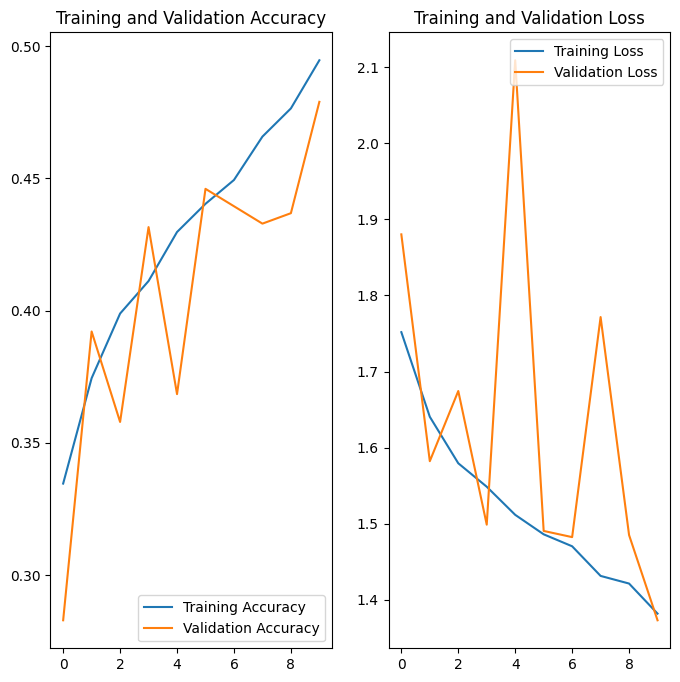

In [101]:
plot_graphs(history2,10)

In [86]:
## Model 3: Using 3 convolutional layers and 2 dense layers

model3 = models.Sequential([
    layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32, kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])


In [87]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,711 (409.03 KB)

 Trainable params: 104,263 (407.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
optm = keras.optimizers.Adam(learning_rate=0.001)

model3.compile(
    optimizer=optm,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [89]:
history3 = model3.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 167s 202ms/step - accuracy: 0.2728 - loss: 1.8648 - val_accuracy: 0.4053 - val_loss: 1.6645
Epoch 2/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 144s 189ms/step - accuracy: 0.3382 - loss: 1.7371 - val_accuracy: 0.4171 - val_loss: 1.5748
Epoch 3/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 201s 188ms/step - accuracy: 0.3431 - loss: 1.6907 - val_accuracy: 0.3553 - val_loss: 1.7030
Epoch 4/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 146s 191ms/step - accuracy: 0.3580 - loss: 1.6698 - val_accuracy: 0.3539 - val_loss: 1.8098
Epoch 5/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 205s 195ms/step - accuracy: 0.3709 - loss: 1.6363 - val_accuracy: 0.1829 - val_loss: 2.0477
Epoch 6/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 144s 189ms/step - accuracy: 0.3905 - loss: 1.6156 - val_accuracy: 0.4171 - val_loss: 1.6050
Epoch 7/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 143s 188ms/step - accuracy: 0.4117 - loss: 1.5831 - val_accuracy: 0.4566 - val_loss: 1.4604
Epoch 8/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 150s 196ms/step - accuracy: 0.4179 -

In [90]:
test_loss, test_accuracy = model3.evaluate(test_ds, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.3653 - loss: 2.3239
Test accuracy: 0.3854


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [102]:
#Model 2 gives the best accuracy.

test_loss, test_accuracy = model2.evaluate(test_ds, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5262 - loss: 1.3529
Test accuracy: 0.5130


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


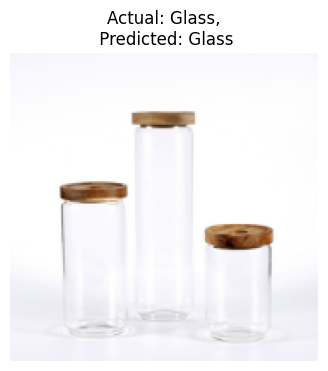

In [106]:
#same predicted label

plt.figure(figsize=(4, 4))
for images, labels in test_ds.take(1):
    for i in range(1):
        ax = plt.subplot(1, 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class= class_names[np.argmax(model2.predict(images)[i])]
        actual_class = class_names[np.argmax(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")

        plt.axis("off")

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

###Data augmentation is used to artificially increase the diversity of the training dataset by applying random transformations such as
###rotation, scaling, and flipping to the images. This helps in improving the generalization capability of the model.

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [70]:
# Create a function to augment the images



data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [71]:
# Create the augmented training dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


##### **4.1.2**

Train the model on the new augmented dataset.

In [73]:
# Train the model using augmented images

model4 = models.Sequential([
    layers.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32, kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [75]:
optm = keras.optimizers.Adam(learning_rate=0.001)

model4.compile(
    optimizer=optm,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history4 = model4.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 148s 193ms/step - accuracy: 0.2702 - loss: 1.8471 - val_accuracy: 0.2605 - val_loss: 2.1511
Epoch 2/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - accuracy: 0.3726 - loss: 1.6561 - val_accuracy: 0.3566 - val_loss: 1.6729
Epoch 3/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - accuracy: 0.3700 - loss: 1.6260 - val_accuracy: 0.3000 - val_loss: 1.9078
Epoch 4/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - accuracy: 0.3964 - loss: 1.5992 - val_accuracy: 0.3829 - val_loss: 1.8530
Epoch 5/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 144s 188ms/step - accuracy: 0.4215 - loss: 1.5622 - val_accuracy: 0.4132 - val_loss: 1.5379
Epoch 6/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - accuracy: 0.4176 - loss: 1.5433 - val_accuracy: 0.4316 - val_loss: 1.5271
Epoch 7/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 202s 190ms/step - accuracy: 0.4086 - loss: 1.5423 - val_accuracy: 0.1947 - val_loss: 3.1783
Epoch 8/15
763/763 ━━━━━━━━━━━━━━━━━━━━ 143s 187ms/step - accuracy: 0.4310 -

In [78]:
test_loss, test_accuracy = model4.evaluate(test_ds, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4517 - loss: 1.5510
Test accuracy: 0.4427


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

Model 2 with 3 Convolutional and 1 dense layers gave the best accuracy.
The break down of the final provided CNN model architecture step by step-

1.Normalization: it involves scaling the pixel values to a range between 0 and 1, which helps in stabilizing the training process and speeding up convergence.

2.Convolutional Layers: Three convolutional layers are added sequentially followed by ReLU.
The padding='same' argument ensures that the spatial dimensions of the feature maps remain the same.
 32, 64, 128 filters or kernels used in each layer

3.Pooling Layers: After each convolutional layer, a max-pooling layer is added to downsample the feature maps, reducing their spatial dimensions while retaining the most important information.
Max-pooling helps in reducing computational complexity and controlling overfitting.

4.Dropout Layer: A dropout layer with a dropout rate of 0.25 is added.Dropout is a regularization technique used to prevent overfitting by randomly dropping a fraction of the neurons during training.

5.Global average pooling Layer is added as final pooling layer to reduce model complexity and parameters

6.Fully Connected Layers: one fully connected (dense) layers is added with ReLU activation functions consisting of 64 neurons.

7.Output Layer: The number of neurons in the output layer is determined by the target_labels variable, representing the number of classes in the classification task.

Model Compilation: The model is compiled using the Adam optimizer (optimizer='adam') and the Categorical Crossentropy loss function is used, which is suitable for multi-class classification problems. Additionally, accuracy is chosen as the evaluation metric

Model with three convolutional layers gave better training and validation accuracy than model with two convolutional layers because of improved feature learning.

After applying all Dropout, BatchNormalization we got this as result:

Final model accuracy:

The final train accuracy is 0.5034
Validation accuracy is 0.4789
The test accuracy is 0.5130